# Assess Genre and Rating Across k

Using the k-nearest neighbors method, use the top-k most similar movies to a target film to predict the target movie's genre and rating.

Use Jaccard similarity based on actors in each movie to rank movies and select the top-k most similar movies.

We want to calculate genre accuracy and rating error across k values in 2..20

In [1]:
import json

import pandas as pd
import numpy as np

from scipy.sparse import lil_matrix

import matplotlib.pyplot as plt


In [2]:
actor_name_map = {}
movie_actor_map = {}
actor_genre_map = {}


with open("../data/imdb_movies_2000to2022.prolific.json", "r") as in_file:
    for line in in_file:
        
        # Read the movie on this line and parse its json
        this_movie = json.loads(line)
        
        # Skip movies with no ratings
        if len(this_movie["rating"]) == 0:
            continue
                    
        # Add all actors to the id->name map
        for actor_id,actor_name in this_movie['actors']:
            actor_name_map[actor_id] = actor_name
            
        # For each actor, add this movie's genres to that actor's list
        for actor_id,actor_name in this_movie['actors']:
            this_actors_genres = actor_genre_map.get(actor_id, {})
            
            # Increment the count of genres for this actor
            for g in this_movie["genres"]:
                this_actors_genres[g] = this_actors_genres.get(g, 0) + 1
                
            # Update the map
            actor_genre_map[actor_id] = this_actors_genres
            
        # Finished with this film
        movie_actor_map[this_movie["imdb_id"]] = ({
            "movie": this_movie["title"],
            "actors": set([item[0] for item in this_movie['actors']]),
            "genres": this_movie["genres"],
            "rating": this_movie["rating"]["avg"]
        })

In [3]:
print("Known Actors:", len(actor_name_map))
print("Known Movies:", len(movie_actor_map))

Known Actors: 29499
Known Movies: 18841


In [4]:
actor_id_to_index = {actor_id:i for i,actor_id in enumerate(actor_name_map.keys())}


## Split Data into Training/Testing Data

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
all_movie_ids = np.array(list(movie_actor_map.keys()))
training_ids, testing_ids = train_test_split(all_movie_ids, test_size=0.1)

In [7]:
training_ids.shape, testing_ids.shape

((16956,), (1885,))

## For Each Movie in Test Set, Use Jaccard Similarity by Actor to Predict Genre and Rating

For each movie in the test set, we find the k most similar movies **in the training set** to predict the test movie's genre and its rating.

Then compare the predictions to the actual data from the `movie_actor_map` to calculate accuracy of this prediction.

In [8]:
performance_by_k_rows = []

for k_nn in range(2,20):
    print("This k:", k_nn)
    
    prediction_rows = []

    for test_movie_id in testing_ids:

        target_movie_object = movie_actor_map[test_movie_id]

        test_movie_similarities = []

        for this_movie_id in training_ids:
            this_movie_obj = movie_actor_map[this_movie_id]

            this_intersect = this_movie_obj["actors"].intersection(target_movie_object["actors"])
            this_union = this_movie_obj["actors"].union(target_movie_object["actors"])

            jaccard = len(this_intersect) / len(this_union)

            test_movie_similarities.append({
                "movie": this_movie_id,
                "jaccard": jaccard,
            })

        similarity_df = pd.DataFrame(test_movie_similarities, columns=["movie", "jaccard"])
        top_movies = similarity_df.sort_values(by="jaccard", ascending=False).head(k_nn)

        relevant_ratings = []
        relevant_genre_count = {}
        for this_movie_id in top_movies["movie"]:
            # add relevant ratings
            relevant_ratings.append(movie_actor_map[this_movie_id]["rating"])

            # Track genres
            this_movie_genres = movie_actor_map[this_movie_id]["genres"]
            for g in this_movie_genres:
                relevant_genre_count[g] = relevant_genre_count.get(g, 0) + 1

        # Get the most common genre from the neighbors
        predicted_genre = sorted(relevant_genre_count, key=relevant_genre_count.get, reverse=True)[0]

        # Take the average rating of k neighbors for prediction
        predicted_rating = np.mean(relevant_ratings)

        # Track predictions
        prediction_rows.append({
            "imdb_id": test_movie_id,
            "genre": predicted_genre,
            "rating": predicted_rating,
        })

    predicted_df = pd.DataFrame(prediction_rows).set_index("imdb_id")

    # Calculate genre accuracy
    correct_genres = []
    for movie_id,row in predicted_df.iterrows():

        actual_genres = movie_actor_map[movie_id]["genres"]
        correct_genres.append(1 if row["genre"] in actual_genres else 0)
    accuracy = sum(correct_genres) / len(correct_genres)



    # Calculate rating accuracy
    rating_mses = []
    for movie_id,row in predicted_df.iterrows():

        actual_rating = movie_actor_map[movie_id]["rating"]
        predicted_rating = row["rating"]

        # Add squared error
        rating_mses.append((actual_rating - predicted_rating) ** 2)
    mse = sum(rating_mses) / len(rating_mses)

    performance_by_k_rows.append({
        "k": k_nn,
        "genre_accuracy": accuracy,
        "rating_mse": mse,
    })

This k: 2
This k: 3
This k: 4
This k: 5
This k: 6
This k: 7
This k: 8
This k: 9
This k: 10
This k: 11
This k: 12
This k: 13
This k: 14
This k: 15
This k: 16
This k: 17
This k: 18
This k: 19


In [9]:
perf_df = pd.DataFrame(performance_by_k_rows)
perf_df

,k,genre_accuracy,rating_mse
0,2,0.379841,2.327219
1,3,0.427056,2.049214
2,4,0.456233,1.893236
3,5,0.487003,1.770386
4,6,0.505570,1.678731
5,7,0.525199,1.634783
6,8,0.538462,1.602023
7,9,0.550133,1.582847
8,10,0.552255,1.568948
9,11,0.562865,1.547330


<AxesSubplot:xlabel='k'>

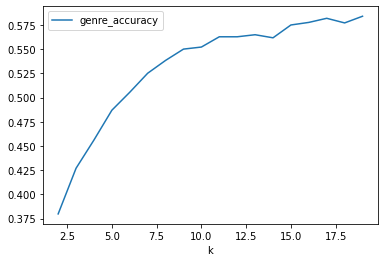

In [10]:
perf_df.plot(x="k", y="genre_accuracy")

<AxesSubplot:xlabel='k'>

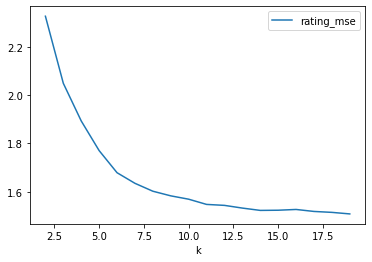

In [11]:
perf_df.plot(x="k", y="rating_mse")